<a href="https://colab.research.google.com/github/KeyMoney22/Plant_disease_classification-/blob/main/tomato_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Relevant Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:

# Mount Google Drive
#drive.mount('/content/drive')

# Navigate to your folder
#folder_path = '/content/drive/MyDrive/PlantVillage'




In [4]:

# Set the path to the dataset directory
dataset_dir = r'C:\Users\Lisa\Desktop\PlantDisease\Tomato'  

## 2. Loading our dataset.

In [5]:
data= tf.keras.utils.image_dataset_from_directory(dataset_dir, labels='inferred', label_mode='categorical',
                                            class_names=None, color_mode='rgb', batch_size=32,
                                            image_size=(256, 256), shuffle=True, seed=None,
                                            validation_split=None, subset=None, interpolation='bilinear',
                                            follow_links=False, crop_to_aspect_ratio=False)

Found 16011 files belonging to 10 classes.


In [6]:
# Checking and printing the length of our data
print('The length of our data is', len(data))

# Checking the shape of our images and labels
for image_batch, label_batch in data:
  print('Image Batch Shape', image_batch.shape)
  print('Label Batch Shape', label_batch.shape)
  break
  #3 = rgb
  #32 = batch size
  # 256, 256= height , weight

The length of our data is 501
Image Batch Shape (32, 256, 256, 3)
Label Batch Shape (32, 10)


### Visualizing some of our images

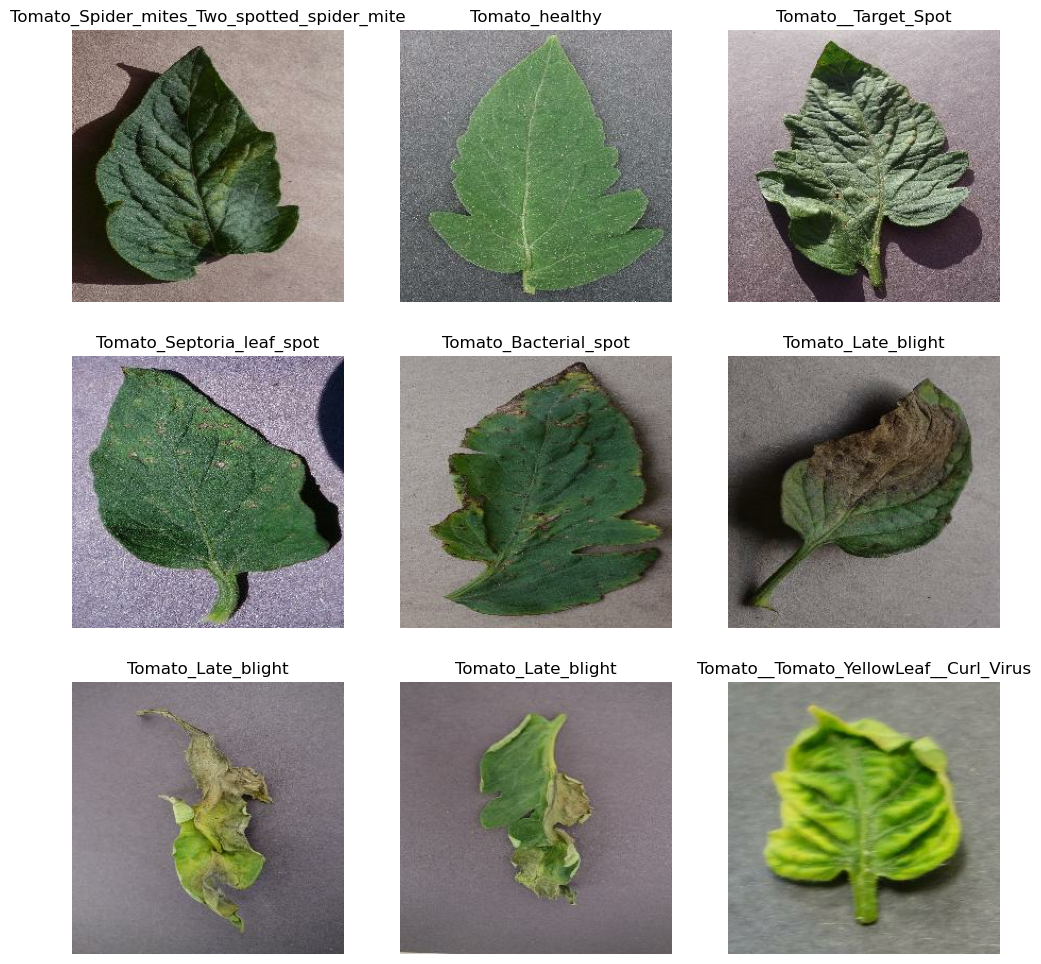

In [7]:
def preview_data(dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")#hide the numbers
    plt.show()

class_names = data.class_names
preview_data(data, class_names)


## 3. Data Cleaning and Preperation

**Cleaning the class names**

In [8]:
#Checking our class names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
# Cleaning and printing the formarted class names
def clean_class_name(name):
    name = name.replace('__', '_')
    name = name.replace('__', '_')
    if name == 'Tomato_Spider_mites_Two_spotted_spider_mite':
        name = 'Tomato_Spider_mites'
    elif name == 'Tomato_Tomato_YellowLeaf_Curl_Virus':
        name = 'Tomato_Yellow_Leaf_Curl_Virus'
    elif name == 'Tomato_Tomato_mosaic_virus':
        name = 'Tomato_Mosaic_Virus'
    name = name.lower()
    return name

class_names = [clean_class_name(name) for name in class_names]
class_names

['tomato_bacterial_spot',
 'tomato_early_blight',
 'tomato_late_blight',
 'tomato_leaf_mold',
 'tomato_septoria_leaf_spot',
 'tomato_spider_mites',
 'tomato_target_spot',
 'tomato_yellow_leaf_curl_virus',
 'tomato_mosaic_virus',
 'tomato_healthy']

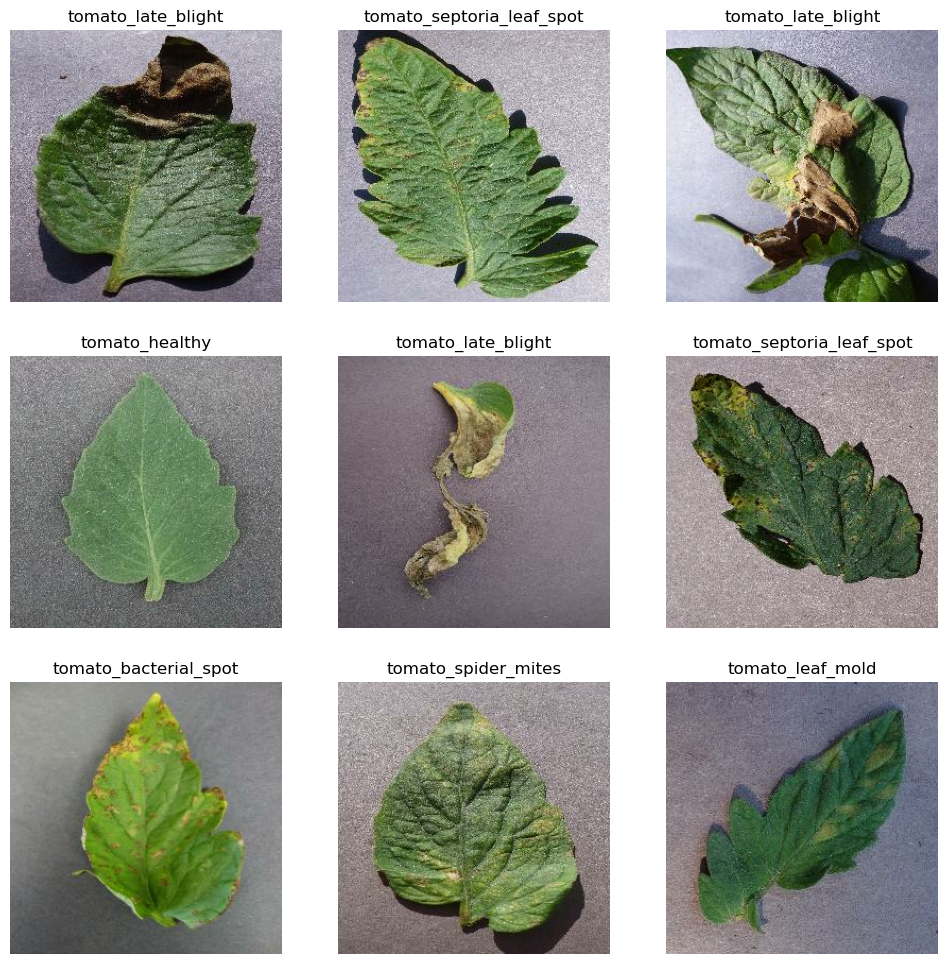

In [10]:
preview_data(data, class_names)

**Checking for Corrupt images**

In [11]:
def check_corrupt_images(dataset_dir):
    corrupt_images = []
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupt_images.append(os.path.join(root, file))
    return corrupt_images

corrupt_images = check_corrupt_images(dataset_dir)
print(f"Found {len(corrupt_images)} corrupt images.")

Found 0 corrupt images.


In [12]:
# Removing Corrupt images
for img_path in corrupt_images:
    try:
      os.remove(img_path)
      print(f"Corrupt image removed:{img_path}")
    except OSError:
      pass

**Class Distribution**

In [13]:
# A function to check class distribution
def check_class_distribution(dataset):
    class_counts = {}
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[tf.argmax(label)]
            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1
    return class_counts

# Checking class distribution
class_distribution = check_class_distribution(data)

# Sorting the dictionary by values (class counts) in ascending order
sorted_class_distribution = dict(sorted(class_distribution.items(), key=lambda item: item[1]))

print("Sorted class distribution (ascending):", sorted_class_distribution)


Sorted class distribution (ascending): {'tomato_mosaic_virus': 373, 'tomato_leaf_mold': 952, 'tomato_early_blight': 1000, 'tomato_target_spot': 1404, 'tomato_healthy': 1591, 'tomato_spider_mites': 1676, 'tomato_septoria_leaf_spot': 1771, 'tomato_late_blight': 1909, 'tomato_bacterial_spot': 2127, 'tomato_yellow_leaf_curl_virus': 3208}


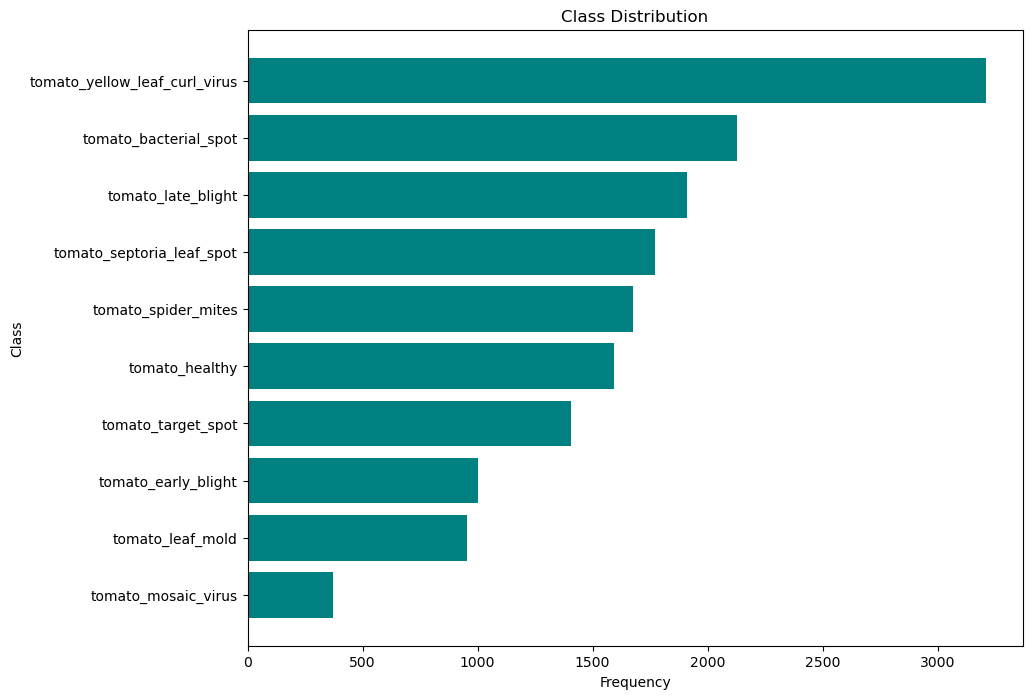

In [14]:
# Visualize class distribution with a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(sorted_class_distribution.keys()), list(sorted_class_distribution.values()), color='Teal')
plt.title('Class Distribution')
plt.xlabel('Frequency')
plt.ylabel('Class')
plt.show();

In our dataset, there is Class imbalance as observed in the graph above, leaf_curl_virus has the highest number of 3208 while tomato mosaic virus with the least observations of 373 as seen on the graph above.

# Data Modeling

**RESNET 50 MODEL**

The image size is set to 256x256 pixels, and the batch size for training is set to 32.

In [15]:
# Set image size and batch size
IMG_SIZE = (256, 256)
BATCH_SIZE = 32


batch_size = BATCH_SIZE
image_size = IMG_SIZE


A preprocessing function is defined to apply ResNet50-specific preprocessing. 

In [16]:
# Preprocessing function
def preprocess(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label


Data augmentation techniques, such as random flipping and rotation, are applied to increase the diversity of the training data

In [17]:
# Data augmentation 
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])


The function create_model constructs a model using transfer learning from a pre-trained ResNet50 model. The base model's layers are frozen, and new layers are added on top, including a global average pooling layer, a dense layer with dropout for regularization, and an output layer with 10 units for the 10 classes. The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss.

In [18]:

# Function to create the model
def create_model():
    base_model = ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential([
        layers.InputLayer(input_shape=IMG_SIZE + (3,)),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # Adjust output layer size
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

The dataset is split into training, validation, and test sets. Data augmentation is applied only to the training set. 
The model is created using the create_model function. 
Early stopping is used to halt training when the validation loss stops improving.
The model is trained using the fit method with the specified datasets and callbacks.

In [19]:
# Loading dataset 
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

# Split the dataset into train, validation, and test sets
val_size = int(0.1 * len(dataset))
test_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size - test_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Apply data augmentation only to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


Found 16011 files belonging to 10 classes.


In [20]:
train_dataset = train_dataset.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)


Datasets are preprocessed and prefetched to improve training efficiency.

In [21]:
# Create and train the model
model = create_model()

C:\Users\Lisa\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [22]:
# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:

# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)




Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1773s 4s/step - accuracy: 0.6757 - loss: 1.0044 - val_accuracy: 0.8487 - val_loss: 0.4219
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1678s 4s/step - accuracy: 0.8724 - loss: 0.3737 - val_accuracy: 0.9156 - val_loss: 0.2244
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1816s 4s/step - accuracy: 0.9057 - loss: 0.2932 - val_accuracy: 0.9131 - val_loss: 0.2414
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1848s 5s/step - accuracy: 0.9188 - loss: 0.2452 - val_accuracy: 0.8900 - val_loss: 0.3519
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1847s 5s/step - accuracy: 0.9211 - loss: 0.2356 - val_accuracy: 0.9381 - val_loss: 0.1755
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1877s 5s/step - accuracy: 0.9283 - loss: 0.2051 - val_accuracy: 0.9225 - val_loss: 0.2300
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1883s 5s/step - accuracy: 0.9324 - loss: 0.1899 - val_accuracy: 0.9306 - val_loss: 0.2148
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 1884s 5s/step - accuracy: 0.9357 - loss: 0.1863 - 

In [24]:
# Get the optimum number of epochs
optimum_epochs = len(history.history['val_accuracy']) - early_stopping.patience

# Print the optimum number of epochs
print("Optimum number of epochs:",optimum_epochs)

Optimum number of epochs: 5


The model is trained for 50 epochs with early stopping based on validation loss, restoring the best weights. The optimal number of epochs is determined to be 5, with the model reaching a validation accuracy of 0.9381 and a validation loss of 0.1755.

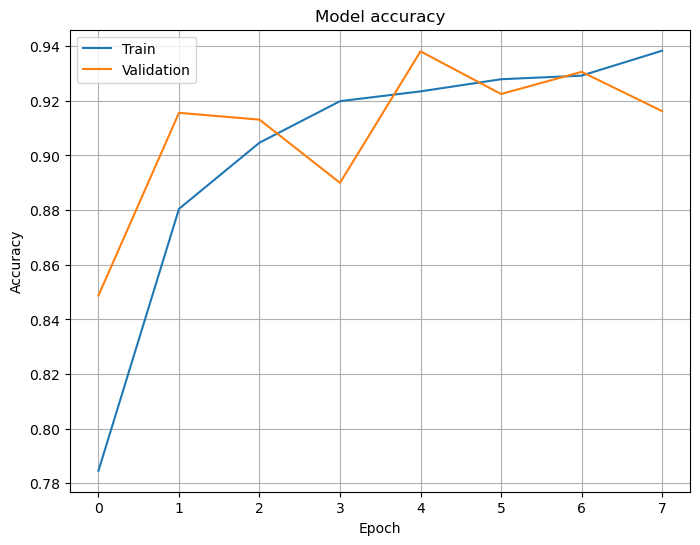

In [25]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

The training accuracy steadily increases, indicating the model is learning from the training data.
The validation accuracy also improves and stabilizes, reaching approximately 0.93, suggesting good generalization to unseen data.

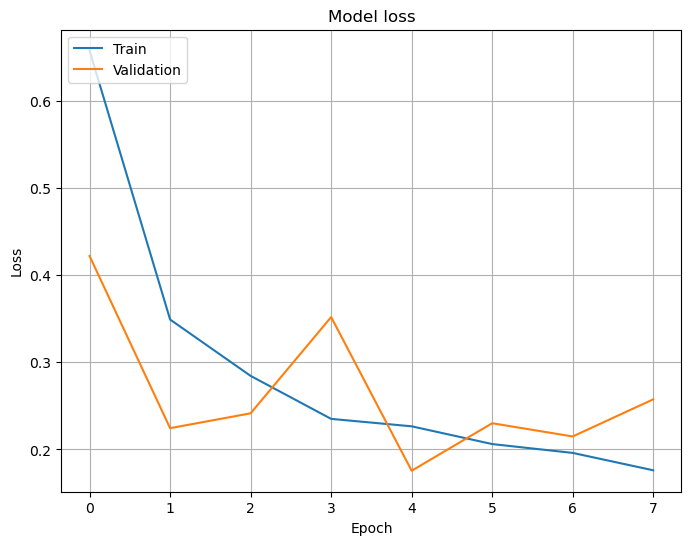

In [31]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()


The training loss consistently decreases, showing the model is effectively minimizing the error on the training data.
The validation loss also decreases and then plateaus, indicating the model is not overfitting and is performing well on the validation data, with the lowest validation loss around 0.17.

In [32]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"test accuracy: {test_acc}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.9443 - loss: 0.1545
test accuracy: 0.9373021125793457


The model achieves a test accuracy of approximately 0.937, indicating good performance on unseen data.

In [33]:
model.save('trained_model.keras')

In [28]:
history.history

{'accuracy': [0.7846009731292725,
  0.8804551362991333,
  0.9046913981437683,
  0.9198877811431885,
  0.9234725832939148,
  0.927914559841156,
  0.9292393922805786,
  0.9383572340011597],
 'loss': [0.6576038599014282,
  0.3490636646747589,
  0.28437212109565735,
  0.23502443730831146,
  0.22648169100284576,
  0.20611831545829773,
  0.1959613561630249,
  0.1760145127773285],
 'val_accuracy': [0.8487499952316284,
  0.9156249761581421,
  0.9131249785423279,
  0.8899999856948853,
  0.9381250143051147,
  0.9225000143051147,
  0.9306250214576721,
  0.9162499904632568],
 'val_loss': [0.4219360053539276,
  0.22435998916625977,
  0.24141515791416168,
  0.35187485814094543,
  0.1755163073539734,
  0.23001112043857574,
  0.21484138071537018,
  0.25744137167930603]}